In [1]:
import glob
import importlib
import sys, os

import numpy as np
import scipy.optimize as op

import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.units as u

import emcee

from dust_extinction.averages import G03_SMCBar
from dust_extinction.parameter_averages import F19

import measure_extinction
from measure_extinction.stardata import StarData
from measure_extinction.extdata import ExtData
from measure_extinction.modeldata import ModelData
from measure_extinction.utils.fit_model import FitInfo

from measure_extinction.utils.helpers import get_full_starfile
from measure_extinction.utils.fit_model import get_best_fit_params, get_percentile_params

from measure_extinction.plotting.plot_spec import plot_multi_spectra, plot_spectrum
from measure_extinction.merge_obsspec import _wavegrid

In [9]:
m31_list = [
"m31_e1_j004354.05+412626.0",
"m31_e2_j004413.84+414903.9",
"m31_e3_j004420.52+411751.1",
"m31_e4_j004427.47+415150.0",
"m31_e5_j004431.66+413612.4",
"m31_e6_j004438.71+415553.5",
"m31_e7_j004454.37+412823.9",
"m31_e8_j004511.82+415025.3",
"m31_e9_j004511.85+413712.9", # some problem with walkers
# "m31_e10_j004512.73+413726.4", # No STIS data
# "m31_e11_j004535.40+414431.5", # No STIS data
"m31_e12_j004539.00+415439.0",
"m31_e13_j004539.70+415054.8",
"m31_e14_j004543.46+414513.6",
"m31_e15_j004546.81+415431.7",
]

Specify the location of the model and observed data

In [10]:
file_path = "/Users/pyanchulova/Documents/extstar_data/"
savefile_path = "/Users/pyanchulova/Documents/ext-science/figs/"
folder = ""

if not os.path.isdir(savefile_path + folder):
    print("making new dir", (savefile_path + folder))
    os.system("mkdir " + savefile_path + folder)

# Karl-level STIS data location
karl_data_path = "~/../../user/kgordon/Python_git/extstar_data/STIS_Data/"

Define star specific parameters

In [11]:
# starname = "m31_e2_j004413.84+414903.9"
starname = m31_list[0]
fstarname = f"{starname}.dat"
velocity = -109.3 # M31 radial velocity from NED
relband = "ACS_F475W"
relband_str = "$F475W$"
starstr = starname.split("m31_")[1].split("_")[0]
print(starname, starstr)

m31_e1_j004354.05+412626.0 e1


Read in the star data

In [7]:
def get_red_star(fstarname, file_path):
    """
    """
    # get the observed reddened star data
    reddened_star = StarData(fstarname, path=f"{file_path}/DAT_files/")
    
    # Turn zeros into NaNs
    for curtype in reddened_star.data.keys():
        reddened_star.data[curtype].fluxes[reddened_star.data[curtype].npts == 0] = np.nan
    
    band_names = reddened_star.data["BAND"].get_band_names()
    data_names = reddened_star.data.keys()
    
    print("band names", band_names)
    print("data names", data_names)
    print("starname", fstarname)
    
    return reddened_star, band_names, data_names

### Plot rebinned spectra with plotting.plot_spec.plot_spectrum

band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e1_j004354.05+412626.0.dat


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e1_j004354.05+412626.0.dat
band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e2_j004413.84+414903.9.dat


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e2_j004413.84+414903.9.dat
band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e3_j004420.52+411751.1.dat


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e3_j004420.52+411751.1.dat
band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e4_j004427.47+415150.0.dat


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e4_j004427.47+415150.0.dat
band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e5_j004431.66+413612.4.dat


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e5_j004431.66+413612.4.dat
band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e6_j004438.71+415553.5.dat


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e6_j004438.71+415553.5.dat
band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e7_j004454.37+412823.9.dat


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e7_j004454.37+412823.9.dat
band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e8_j004511.82+415025.3.dat


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e8_j004511.82+415025.3.dat
band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e9_j004511.85+413712.9.dat


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e9_j004511.85+413712.9.dat
band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e12_j004539.00+415439.0.dat


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e12_j004539.00+415439.0.dat
band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e13_j004539.70+415054.8.dat


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e13_j004539.70+415054.8.dat
band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e14_j004543.46+414513.6.dat


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e14_j004543.46+414513.6.dat
band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e15_j004546.81+415431.7.dat


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e15_j004546.81+415431.7.dat


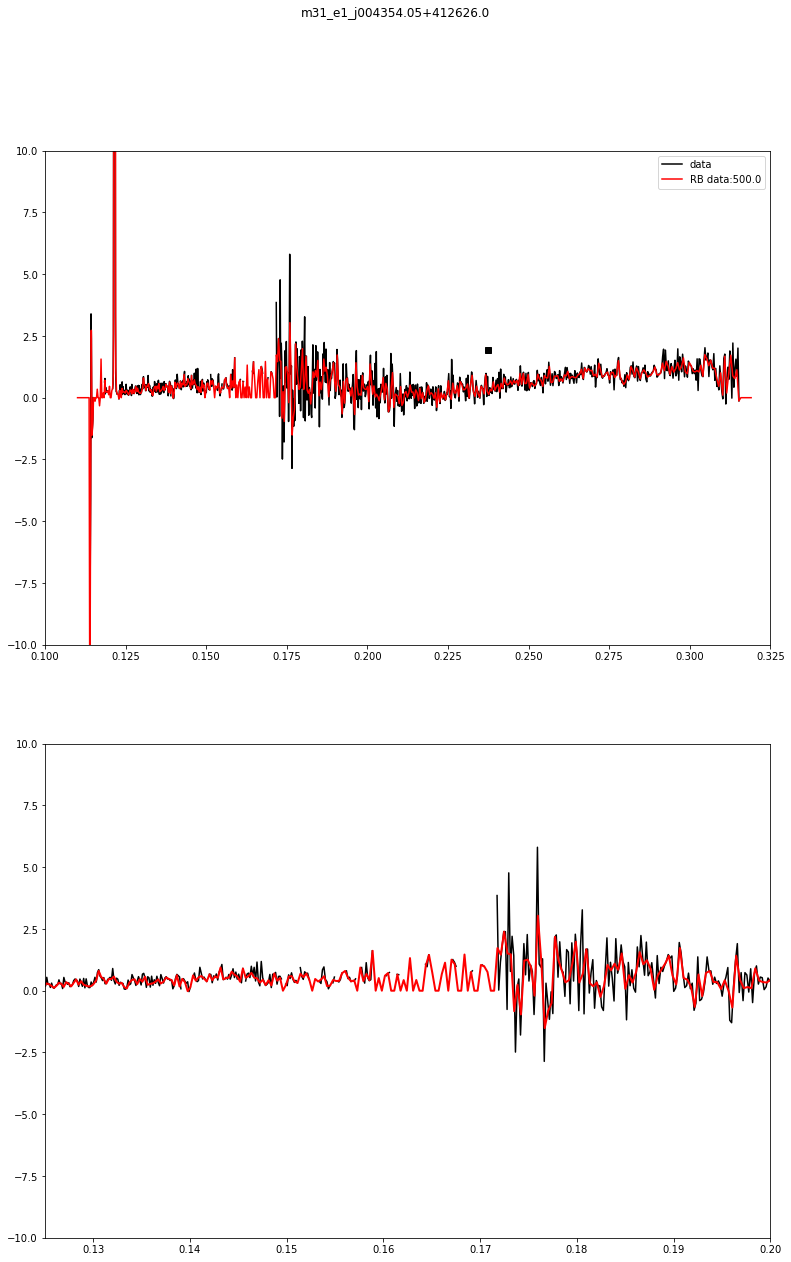

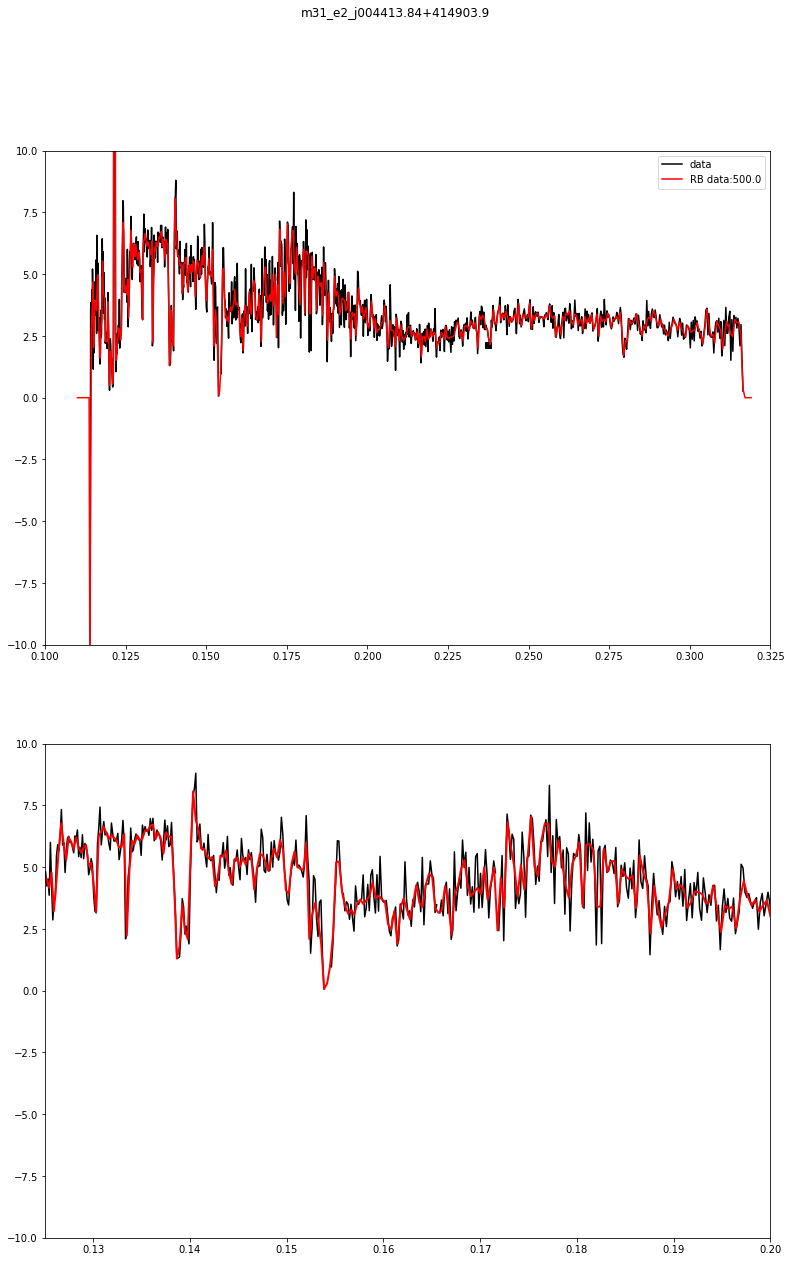

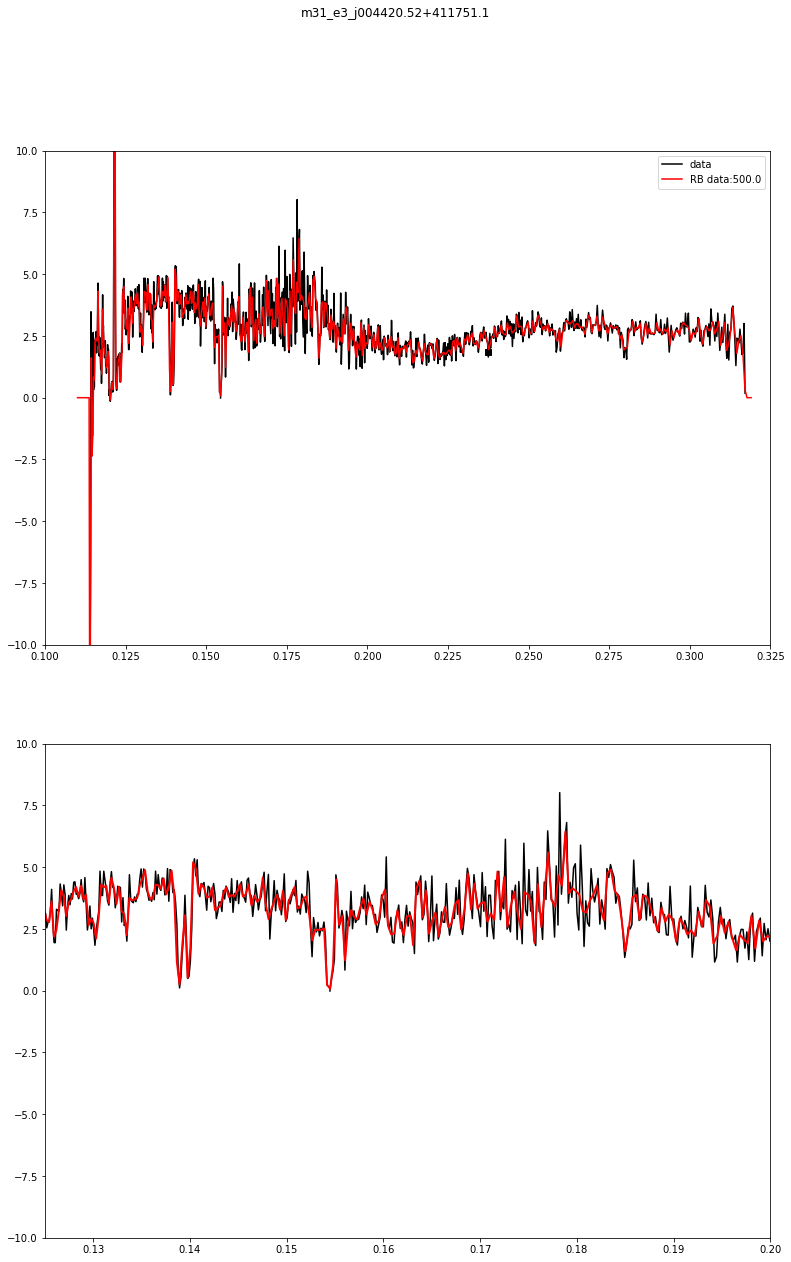

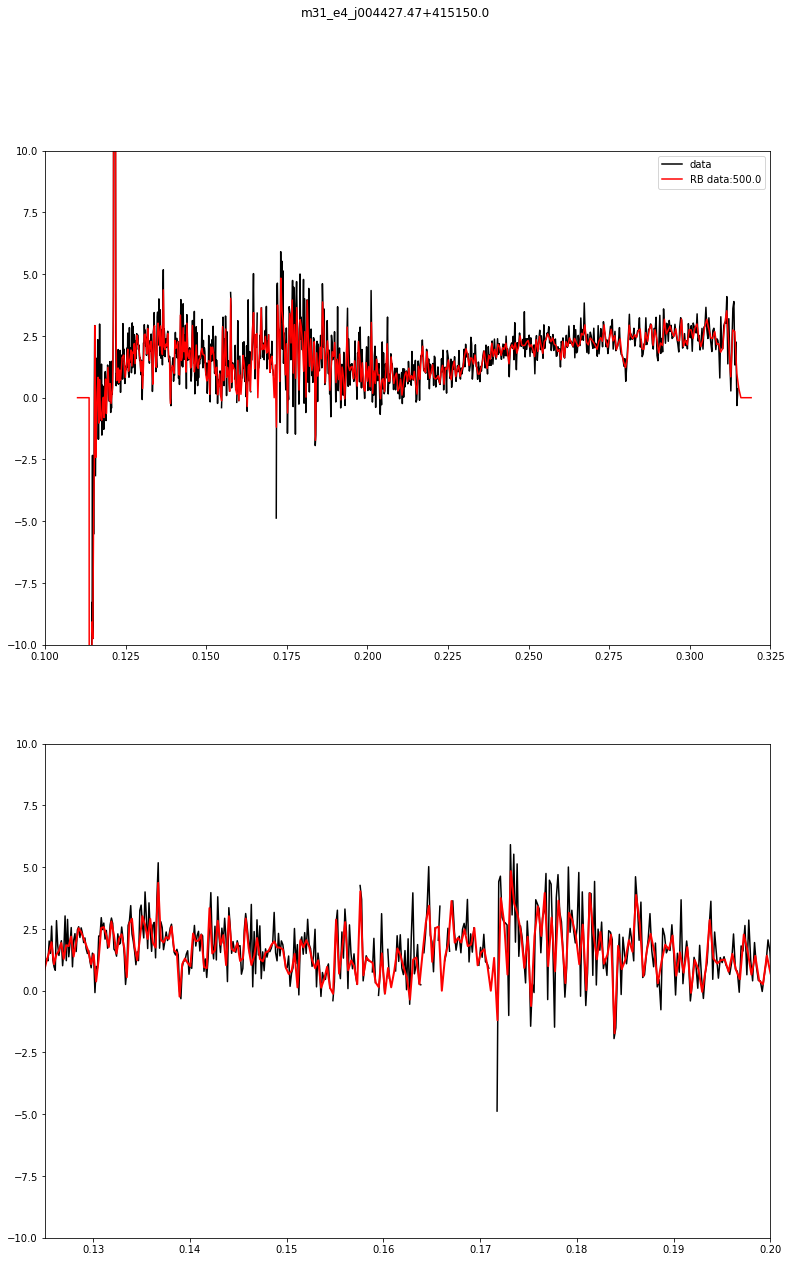

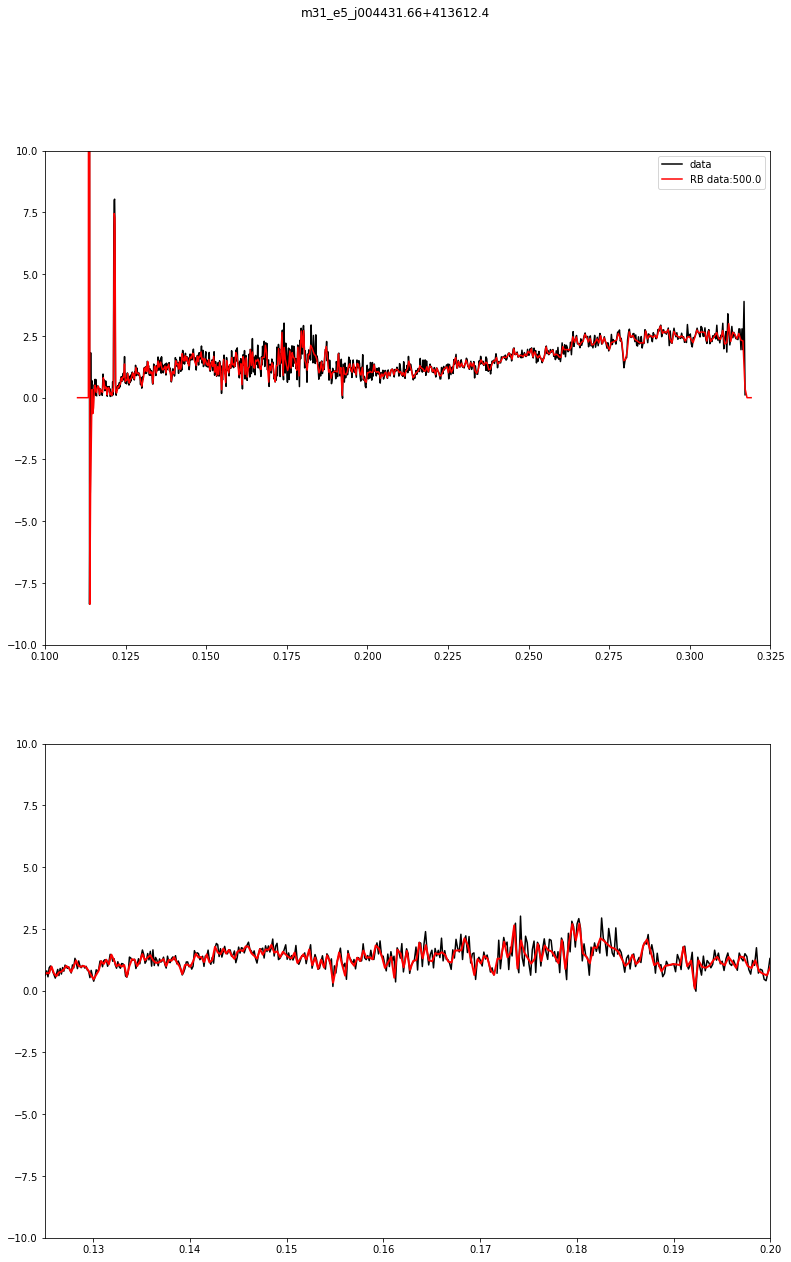

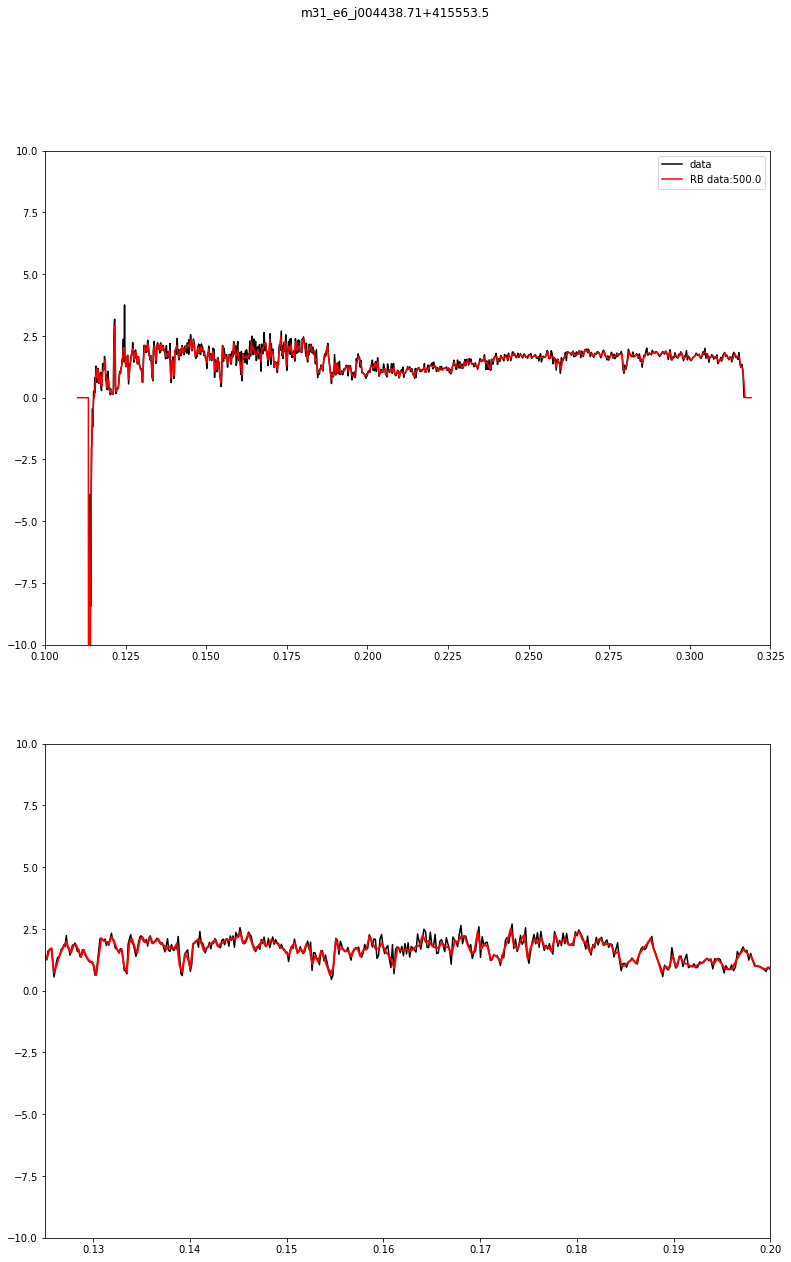

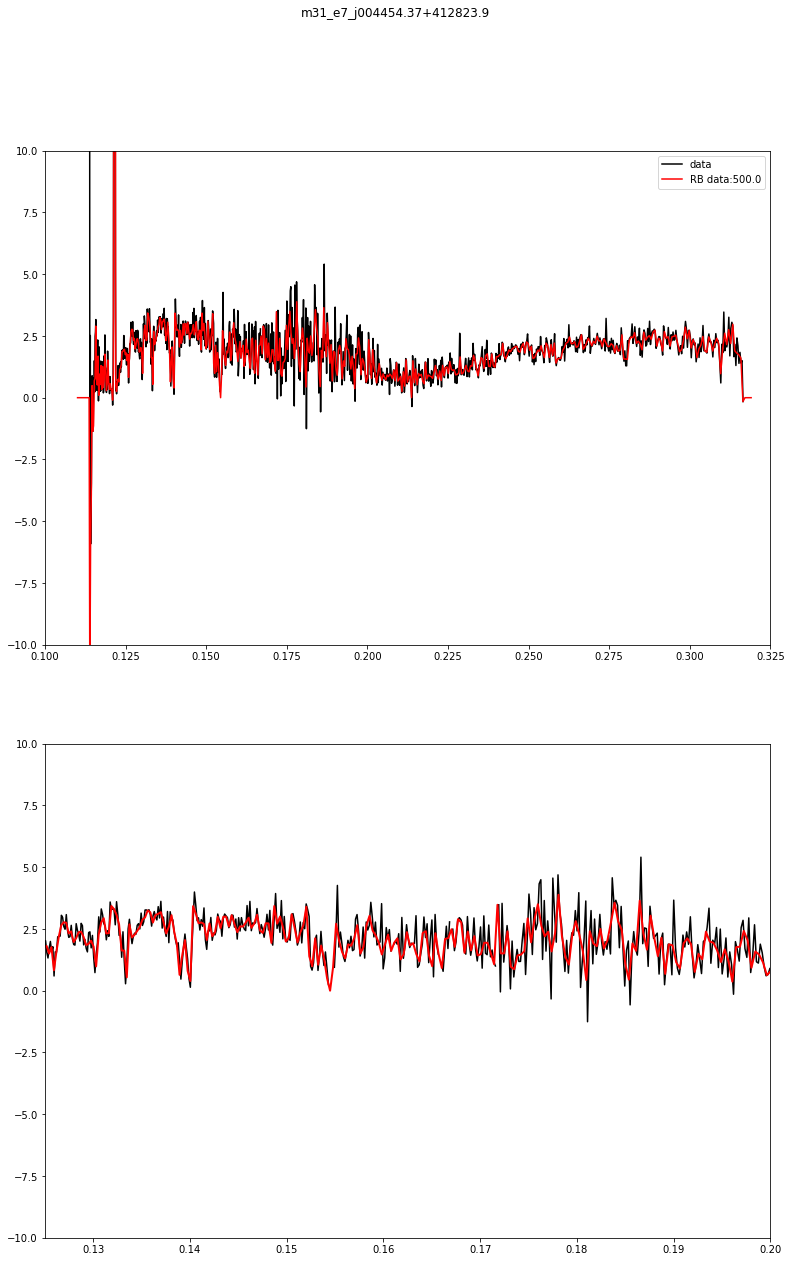

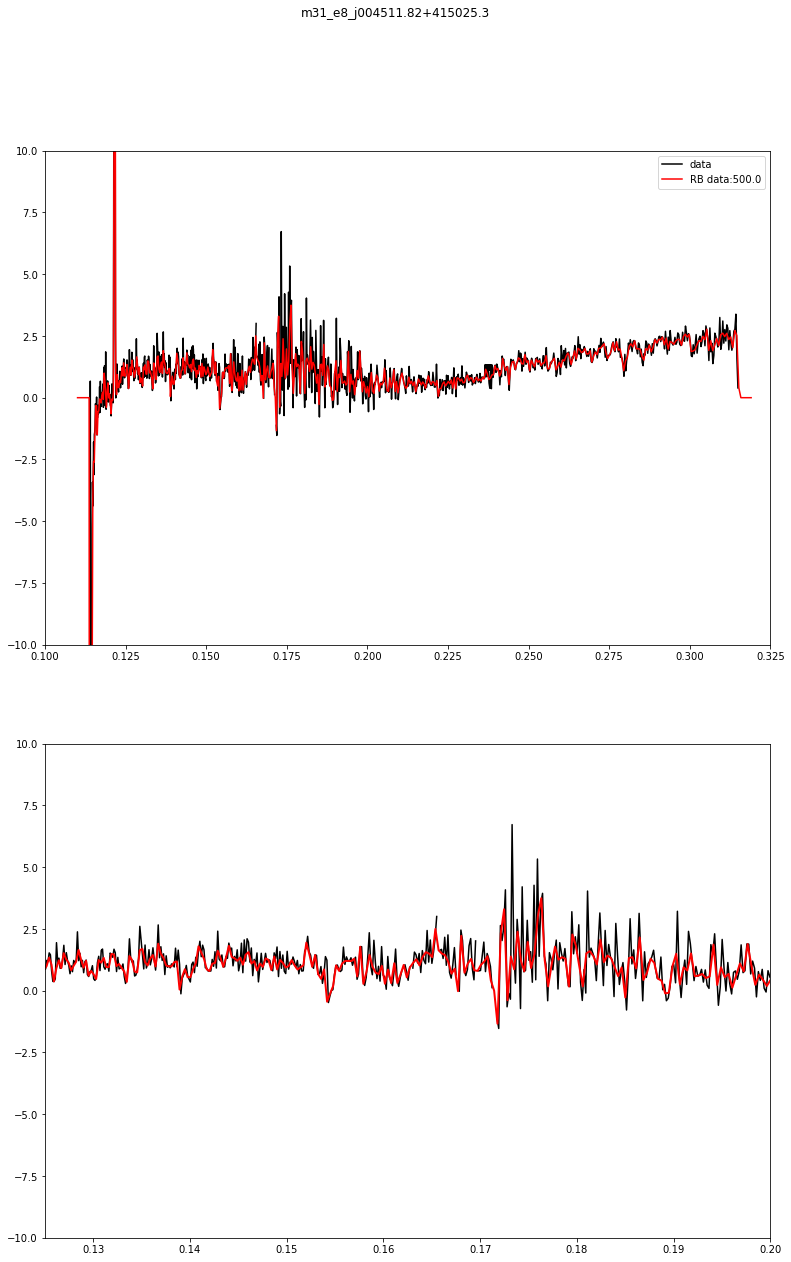

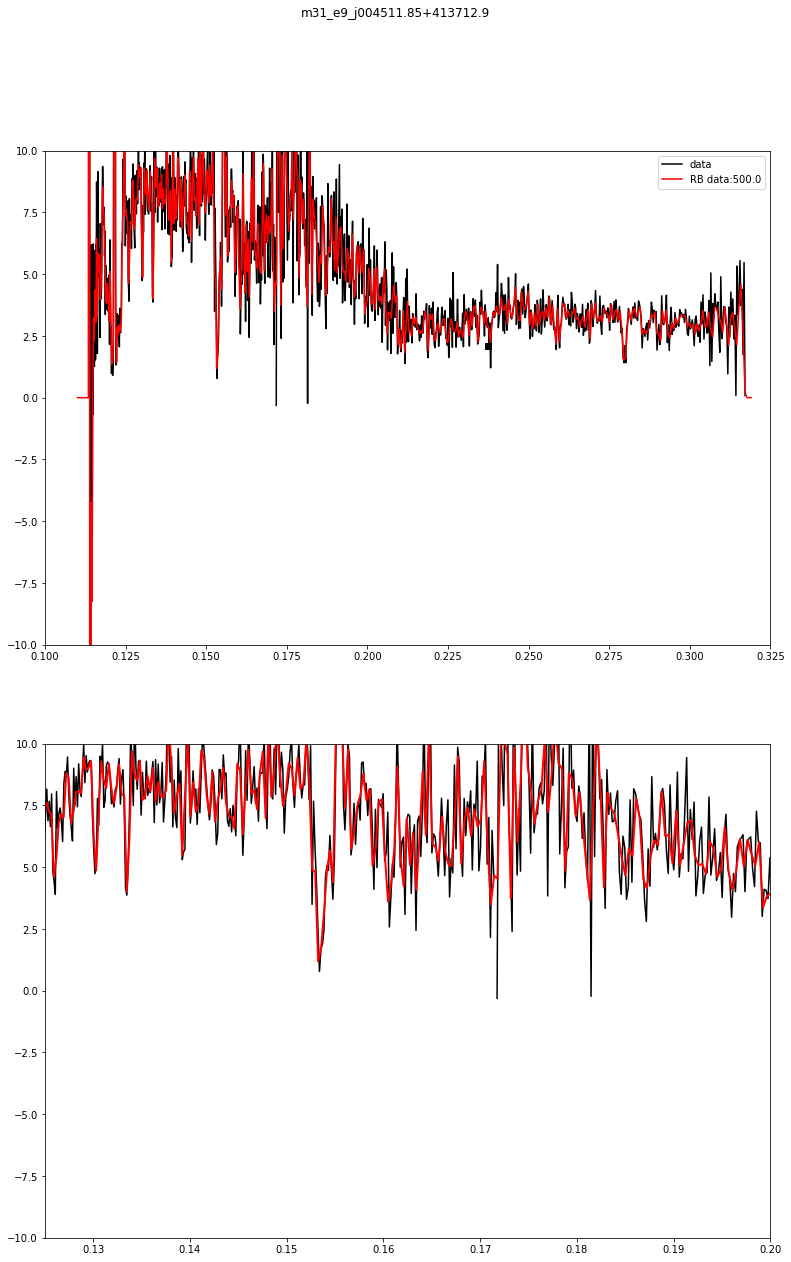

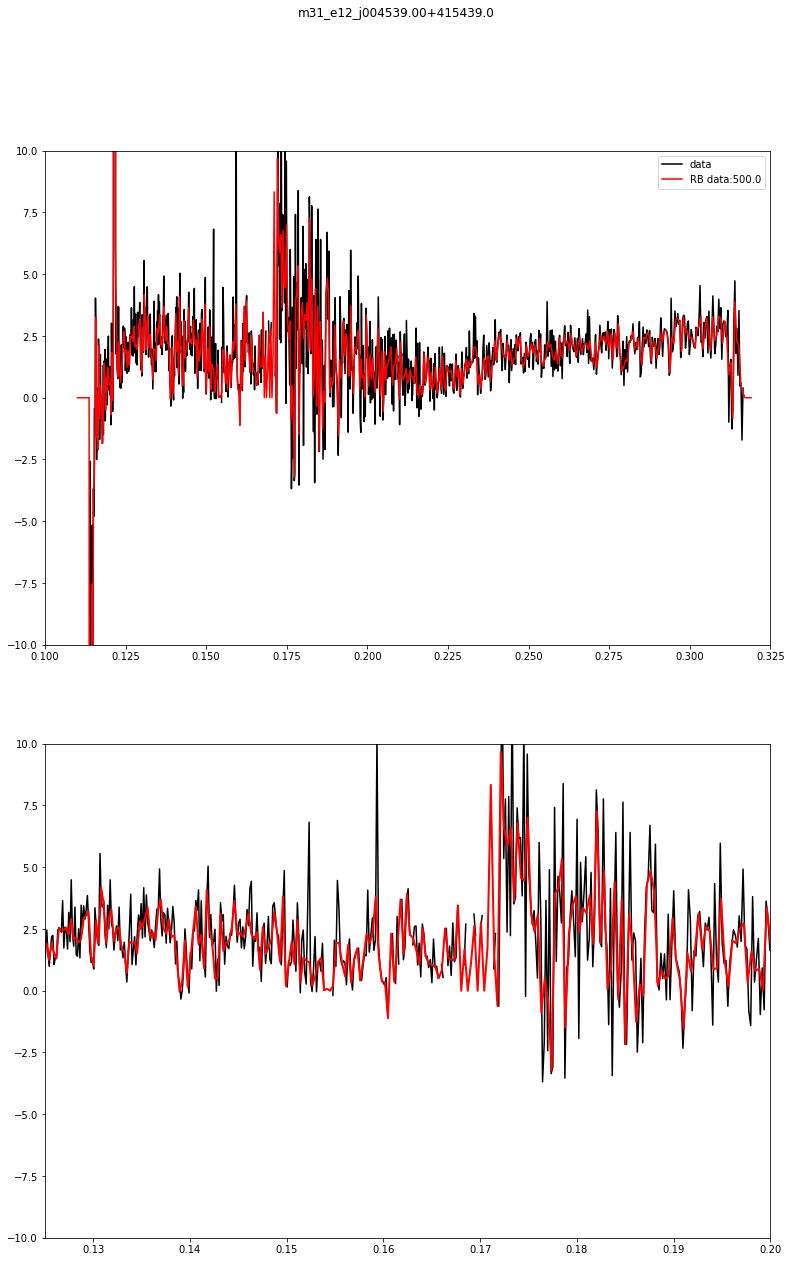

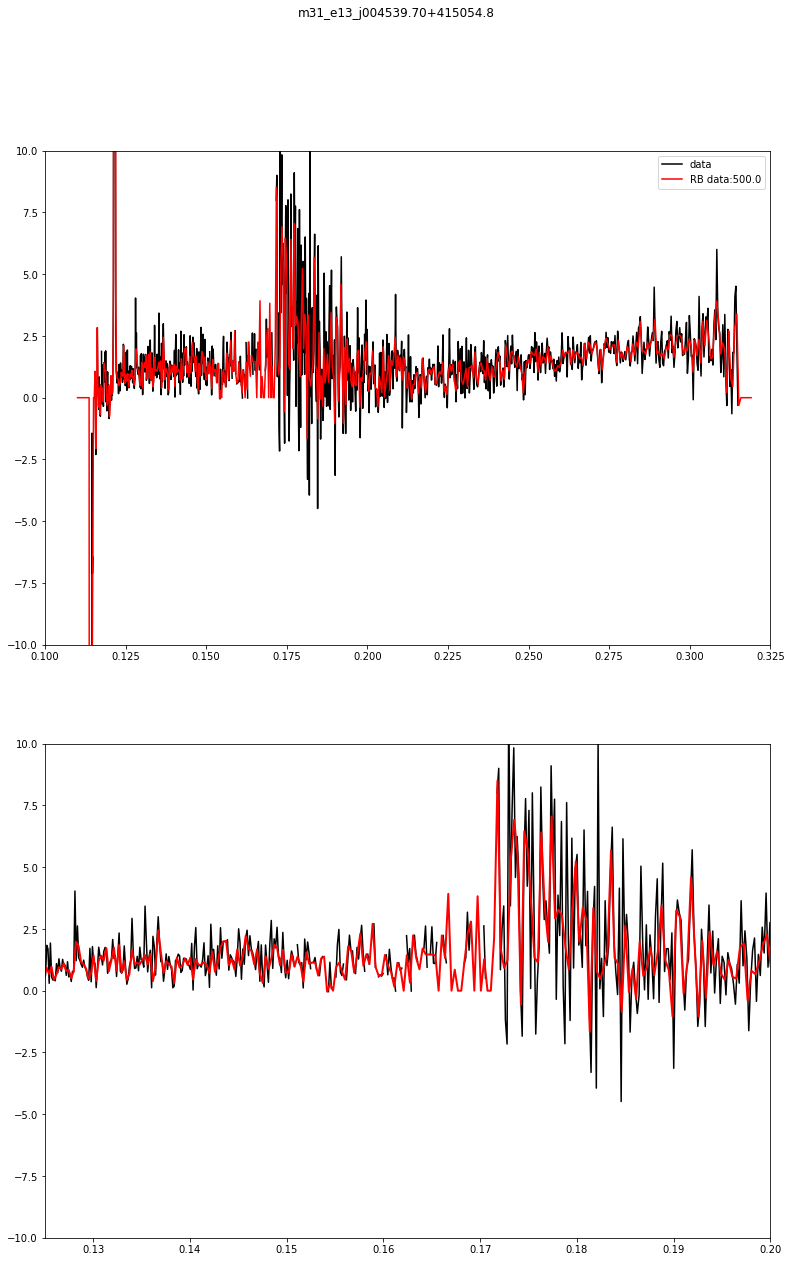

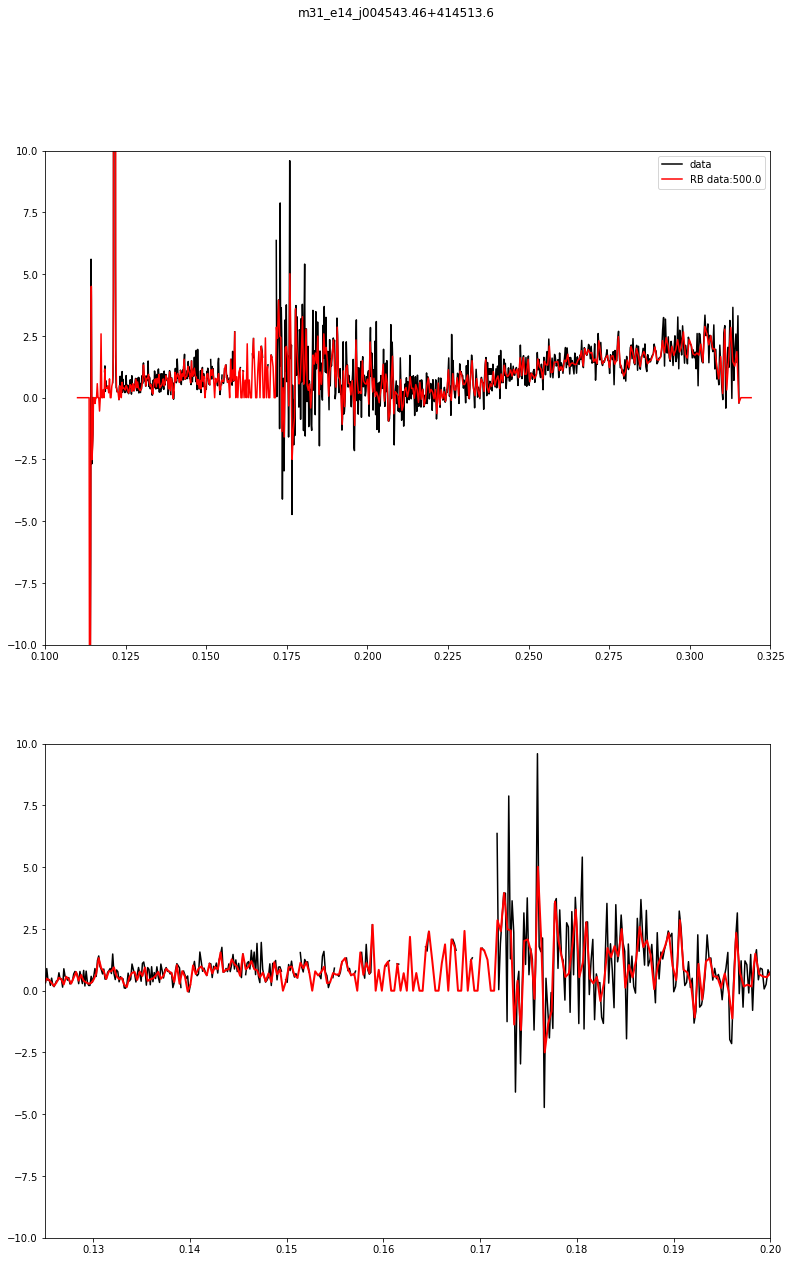

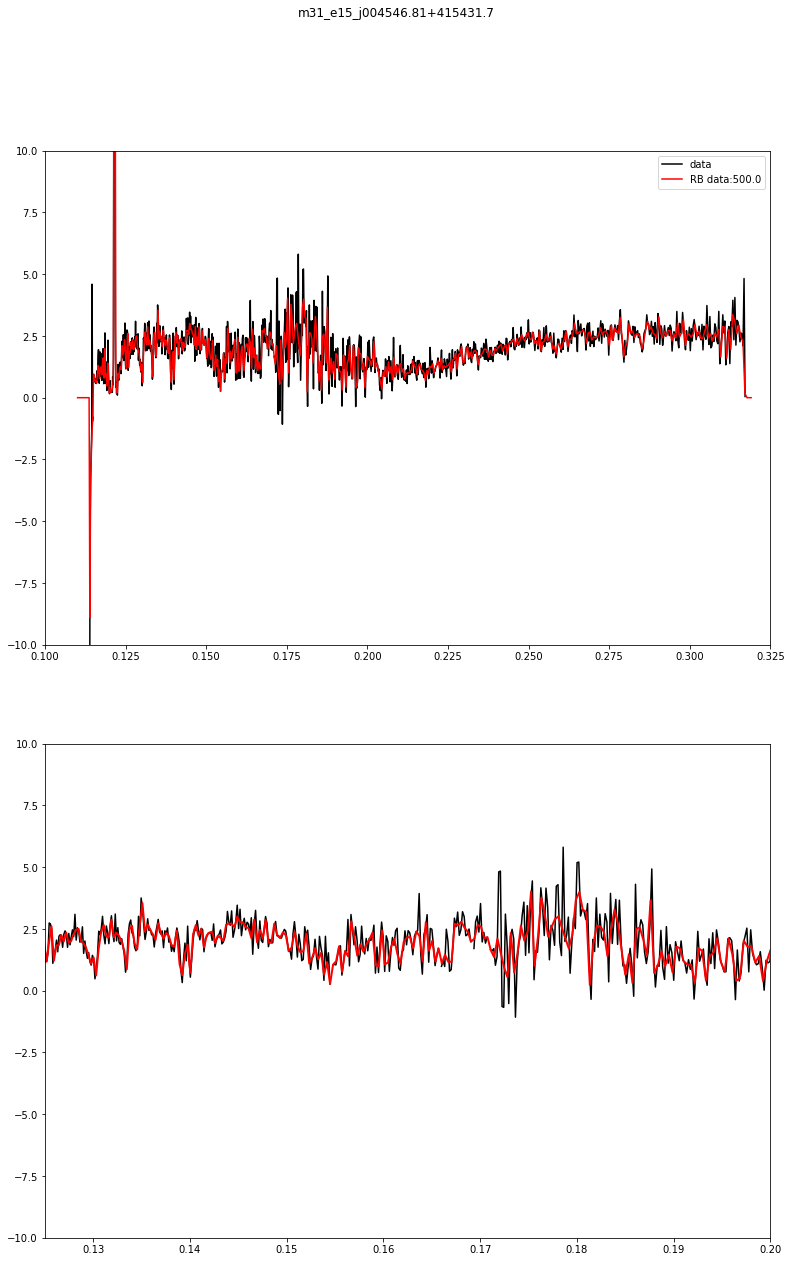

In [8]:
for i in range(len(m31_list)):

    starname = m31_list[i]
    fstarname = f"{starname}.dat"
    path = f"{file_path}/DAT_files/"
    starstr = starname.split("m31_")[1].split("_")[0]

    # default settings
    #plot_spectrum(starname, path)
    # zoomed in
    #plot_spectrum(starname, path, range=[0.25, 0.3])

    # Get star data
    red_star, band_names, data_names = get_red_star(fstarname, file_path)
    norm_data = np.average(red_star.data["BAND"].fluxes)


    # ================== UV spectra WL range only ==============
    fig, (ax,ax2) = plt.subplots(2, 1, figsize=(13, 20))

    # Rebin params
    # Testing resolutions: 125, 250, 500, 750; Data max = 1000; > Data max: 1250, 1500, 2000
    gres = tres / 2.0
    rwaverange = [0.11, 0.32] * u.micron

    # plot the bands and all spectra for this star
    for cspec in data_names:
        ptype = "-"
        label="data"
        if cspec == "BAND":
            ptype = "s"
            label=""

        norm_flux = red_star.data[cspec].fluxes / norm_data
        # Default observations
        ax.plot(
            red_star.data[cspec].waves,
            norm_flux,
            "k" + ptype,
            label=label,
        )

        # Rebin STIS spectra
        if cspec == "STIS":
            spec_rb = red_star.data[cspec]
            spec_rb.rebin_constres(rwaverange, gres)

            # Plot rebinned spectra
            ax.plot(
                spec_rb.waves,
                spec_rb.fluxes / norm_data,
                "r" + ptype,
                label="RB data:{}".format(gres) ,
            )
    #     ax.set_ylim(-0.1e-15, 0.7e-15)
        ax.set_ylim(-10, 10)
        ax.set_xlim(0.1,0.325)
        ax.legend()

    # ============ Zoomed plot ==================
    red_star, band_names, data_names = get_red_star(fstarname, file_path)

    for cspec in data_names:

        # zoomed plot
        norm_flux = red_star.data[cspec].fluxes / norm_data
        ax2.plot(
            red_star.data[cspec].waves,
            norm_flux,
            "k" + ptype,
        )
        if cspec == "STIS":
            ax2.plot(
                spec_rb.waves,
                spec_rb.fluxes / norm_data,
                "r" + ptype,
                lw=2
        )
        ax2.set_ylim(-10, 10)
        ax2.set_xlim(0.125,0.2)

    plt.suptitle(starname)

    # figs with NaN have zero fluxes turned to NaNs to exclude from plotting or calcs
    plt.savefig(savefile_path + starstr + "_NaN_" + str(gres) + "res.pdf")

### Plot offset spectra

m31_e15_j004546.81+415431.7
band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e15_j004546.81+415431.7.dat


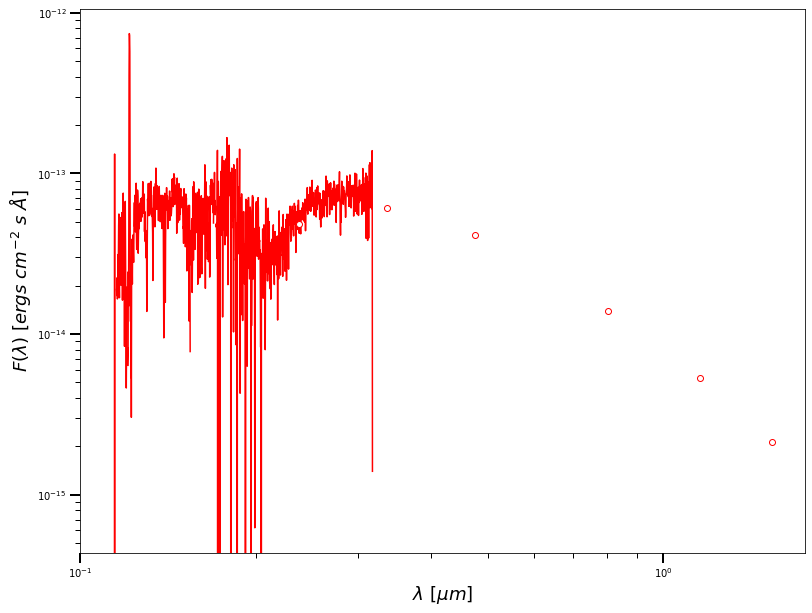

In [7]:
fig, ax = plt.subplots(figsize=(13, 10))
fontsize=14
colors = ['r','gold',#'b','g',
          'k','c','magenta','gray',
          'lime','tomato','deepskyblue',
          'purple',
          'deeppink', 'teal', 'darkgray']
plot_one=False
yoffset=300
yot='multiply'
for i in range(len(m31_list)):
    if plot_one:
        fstarname = f"{starname}.dat"
    else:
        starname = m31_list[i]
        print(starname)
        fstarname = f"{starname}.dat"

    reddened_star, band_names, data_names = get_red_star(fstarname, file_path)
#     print(i, fstarname)
    reddened_star.plot(ax, pcolor=colors[i], yoffset=yoffset, yoffset_type=yot)
    this_offset = yoffset
    yoffset+=np.log(yoffset)
ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_ylim(1e-15, 1e-12)
# ax.set_xlim(0.11, 0.33)
# ax.set_xlim(0.33, 1.5)
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")
plt.savefig(savefile_path + starstr + "_spectra_yoffset_" + str(this_offset) + ".png")

## Get reddened star data

In [161]:
reddened_star, band_names, data_names = get_red_star(fstarname, file_path)

band names ['WFC3_F275W', 'WFC3_F336W', 'ACS_F475W', 'ACS_F814W', 'WFC3_F110W', 'WFC3_F160W']
data names dict_keys(['BAND', 'STIS'])
starname m31_e15_j004546.81+415431.7.dat


## Get the model data

In [63]:
tlusty_models_fullpath = glob.glob("{}/Models/tlusty_*v10.dat".format(file_path))
# tlusty_models_fullpath = tlusty_models_fullpath[0:10]
tlusty_models = [
    tfile[tfile.rfind("/") + 1 : len(tfile)] for tfile in tlusty_models_fullpath
]

# get the models with just the reddened star band data and spectra
modinfo = ModelData(
    tlusty_models,
    path="{}/Models/".format(file_path),
    band_names=band_names,
    spectra_names=data_names,
)

print("log(Teff) range:", modinfo.temps_min, modinfo.temps_max)
print("log(g) range:", modinfo.gravs_min, modinfo.gravs_max)
print("log(Z) range:", modinfo.mets_min, modinfo.mets_max)

log(Teff) range: 4.176091259055681 4.740362689494244
log(g) range: 1.75 4.75
log(Z) range: -1.0 0.3010299956639812


Create the weight arrays based on the observed uncertainties

In [9]:
def set_weights(data_names, reddened_star):
    """
    """
    # cropping info for weights
    #  bad regions are defined as those where we know the models do not work
    #  or the data is bad
    # pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]
    ex_regions = [
        [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
        [8.7, 10.0],  # bad data from STIS
        [3.55, 3.6],
        [3.80, 3.90],
        [4.15, 4.3],
        [6.4, 6.6],
        [7.1, 7.3],
        [7.45, 7.55],
        [7.65, 7.75],
        [7.9, 7.95],
        [8.05, 8.1],
    ] / u.micron

    weights = {}
    for cspec in data_names:
        weights[cspec] = np.full(len(reddened_star.data[cspec].fluxes), 0.0)
        gvals = reddened_star.data[cspec].npts > 0
        weights[cspec][gvals] = 1.0 / reddened_star.data[cspec].uncs[gvals].value

        x = 1.0 / reddened_star.data[cspec].waves
        for cexreg in ex_regions:
            weights[cspec][np.logical_and(x >= cexreg[0], x <= cexreg[1])] = 0.0

    # make the photometric bands have higher weight
    weights["BAND"] *= 10000.0
    print("weight arrays set")
    return weights

### Plot the spectra

In [169]:
def plot_spectra_with_mod(hi_ext_modsed, reddened_star, modesed, ext_modsed, \
                          modsed_stardata, starstr, folder=''):
    """
    """
    norm_model = np.average(hi_ext_modsed["BAND"])
    norm_data = np.average(reddened_star.data["BAND"].fluxes)

    # plotting setup for easier to read plots
    fontsize = 16
    font = {"size": fontsize}
    mpl.rc("font", **font)
    mpl.rc("lines", linewidth=1)
    mpl.rc("axes", linewidth=2)
    mpl.rc("xtick.major", width=2)
    mpl.rc("xtick.minor", width=2)
    mpl.rc("ytick.major", width=2)
    mpl.rc("ytick.minor", width=2)

    # setup the plot
    fig, ax = plt.subplots(figsize=(14, 12))

    # plot the bands and all spectra for this star
    for cspec in modinfo.fluxes.keys():
        if cspec == "BAND":
            ptype = "o"
        else:
            ptype = "-"

        # ax.plot(reddened_star.data[cspec].waves, weights[cspec], 'k-')

        # Observations
        ax.plot(
            reddened_star.data[cspec].waves,
            reddened_star.data[cspec].fluxes / norm_data,
            "k" + ptype,
            label="data",
        )

        # Intrinsic SED
        ax.plot(
            modinfo.waves[cspec], modsed[cspec] / norm_model, "b" + ptype, label=cspec
        )
        
        # dust_extinguished sed
        ax.plot(
            modinfo.waves[cspec],
            ext_modsed[cspec] / norm_model,
            "r" + ptype,
            label=cspec,
        )
        
        # hi abs sed
        ax.plot(
            modinfo.waves[cspec],
            hi_ext_modsed[cspec] / norm_model,
            "g" + ptype,
            label=cspec,
        )

    # finish configuring the plot
#     ax.set_ylim(8e4 / norm_model, 6e9 / norm_model)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")

    # ax.legend()

    # use the whitespace better
    fig.tight_layout()
    
    # pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]
    logt_round = np.around(params[0], decimals=2)
    logg_round = np.around(params[1], decimals=2)
    av_round = np.around(params[3], decimals=2)
    rv_round = np.around(params[4], decimals=2)
    c2_round = np.around(params[5], decimals=2)
    c3_round = np.around(params[6], decimals=2)
    c4_round = np.around(params[7], decimals=2)
    x0_round = np.around(params[8], decimals=2)
    g_round = np.around(params[9], decimals=2)
    print("Fig params are log(T)=%s, log(g)=%s, Av=%s" % (params[0], params[1], params[3]))
    
    # Generate a name to record the star and its parameters
    param_combo_str = "_T_" + str(logt_round)  + "_g_" + str(logg_round) + \
                "_Av_"  + str(av_round) + "_Rv_" + str(rv_round) + "_c2_" + \
                str(c2_round) + "_c3_" + str(c3_round) + "_c4_" + str(c4_round) + "_x_" + \
                str(x0_round) + "_gamma_" + str(g_round)
    print("star", starstr)
    ax.set_title(starstr + param_combo_str, y=0.95)
    if 'e6' in fstarname:
        ax.set_xlim(0.1, 1)

    plt.savefig(savefile_path + starstr + "_spectra1" + ".png")
#     plt.close()

### Setup the fit parameters

In [103]:
def setparams(logt=4.25, logg=3.09, logz=0.0, av=0.75, rv=3.1, c2=2.5, c3=0.65, c4=0.26, \
              x0=4.66, g=0.86 , hig=21.0, himw=19.0):
    """
    """
    # parameter names
    pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]

    # initial starting position
    #  **customize for each star**
    # SMC metallicity -> 0.2 (1/5 solar)
    # Original params list
    # params = [4.25, 3.09, 0.2, 0.75, 3.7, 2.5, 0.65, 0.26, 4.66, 0.86, 22.0, 19.0]

    params = [logt, logg, logz, av, rv, c2, c3, c4, x0, g, hig, himw]

    # min/max allowed values for each parameter
    # some are based on the min/max of the stellar atmosphere grid
    plimits = [
            [modinfo.temps_min, modinfo.temps_max],  # log(Teff)
            [modinfo.gravs_min, modinfo.gravs_max],  # log(g)
            [modinfo.mets_min, modinfo.mets_max],    # log(Z)
            [0.0, 4.0],   # Av
            [2.0, 6.0],   # Rv
            [-0.1, 5.0],  # C2
            [0.0, 2.5],   # C3
            [0.0, 1.0],   # C4
            [4.5, 4.9],   # xo
            [0.6, 1.5],   # gamma
            [17.0, 24.0], # log(HI) internal to galaxy
            [17.0, 22.0], # log(HI) MW foreground
        ]

    # add Gaussian priors based on prior knowledge
    #  sptype -> log(Teff), log(g)
    #  galaxy metallicity -> log(Z)
    print("Priors are logT={}, logg={}, logZ={}".format(logt, logg, logz))
    ppriors = {}
    ppriors["logT"] = (logt, 0.1)
    ppriors["logg"] = (logg, 0.1)
    ppriors["logZ"] = (logz, 0.1)

    return pnames, params, plimits, ppriors    

Package the fit info needed.  FitInfo class defines the likelihood functions as well.

In [104]:
def package_fitinfo(pnames, plimits, weights, ppriors, velocity):
    """
    """
    ppriors=None
    fitinfo = FitInfo(
        pnames,
        plimits,
        weights,
        parameter_priors=ppriors,
        stellar_velocity=velocity,
    )
    return fitinfo

#### Turn log(likelihood) into chi^2
Needed since op.minimize searchs for the min chisqr (not max likelihood like MCMC algorithms)

In [105]:
def nll(*args):
    return -fitinfo.lnprob(*args)

# simple function to turn the log(likelihood) into the chisqr
# requied as op.minimize function searchs for the minimum chisqr (not max likelihood like MCMC algorithms)
def log_l_to_chi2(fitinfo, params, reddened_star, modinfo, method="Nelder-Mead"): #, maxiter
    """
    nll = function to be minimized
    params = initial guess
    method = type of solver
    args = extra arguments passed to the fn to be minimized
    """

    # run the fit
    result = op.minimize(
        nll, params, method="Nelder-Mead", 
        args=(reddened_star, modinfo, fitinfo), options={"maxiter": 1000})
    
    # check the fit output
    print("in log_l_to_chi2.", result["message"])
    print("Success?", result["success"])
    return result

### Save dust param results based on optimizer calc

In [106]:
# save results
def save_results(result, pnames):
    """
    """
    params = result["x"]
    # print("\n result in save_results()", result["x"])
    fit_params = params
    params_best = params
    pnames_extra = pnames

    # print the best fit
    print("Printing the best fit")
    for k, val in enumerate(params_best):
        print("{} # {}".format(val, pnames_extra[k]))
        
    return params, fit_params, params_best, pnames_extra


#### Calculate and save the extinction curve

In [107]:
def calc_plot_ext_curve(fit_params, velocity, relband, reddened_star, starname, params):
    """
    """
    # intrinsic sed: log(T), log(g), Z, Av
    modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

    # dust_extinguished sed: Av, etc.
    ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

    # hi_abs sed
    hi_ext_modsed = modinfo.hi_abs_sed(
        fit_params[10:12], [velocity, 0.0], ext_modsed
    )

    # create a StarData object for the best fit SED
    modsed_stardata = modinfo.SED_to_StarData(modsed)

    # create an extincion curve and save it
    extdata = ExtData()
    extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
    col_info = {"av": fit_params[3], "rv": fit_params[4]}
    extdata.save("extcurves/" + starstr + "_ext1.fits", column_info=col_info)
    print("extinction curve type", extdata.type)
    
    
    # =============== PLOT the extinction curve =========================
    fig, ax = plt.subplots(figsize=(13, 10))

    # convert from E(l-V) to A(l)/A(V)
    # print(extdata.type_rel_band != "V")
    extdata.columns["AV"] = (params[3], 0.0)
    # extdata.trans_elv_alav()
    # extdata.trans_elv_elvebv()

    extdata.plot(ax, color='deepskyblue')#, alax=True)
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    # ax.set_ylim(0.0, 10.0)
    ax.set_ylabel(fr"$E(\lambda$ - %s)" % relband_str, fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")

    # plot known exitnction curves
    mod_x = np.arange(0.3, 8.7, 0.1) / u.micron
    smcbar = G03_SMCBar()
    Af475wAv = smcbar(0.475 * u.micron)
    smcbar_el475w = (smcbar(mod_x) - Af475wAv) * params[3]
    ax.plot(1.0 / mod_x, smcbar_el475w, "k:")

    f19_rv31 = F19(Rv=3.1)
    Af475wAv = f19_rv31(0.475 * u.micron)
    f19_el475w = (f19_rv31(mod_x) - Af475wAv) * params[3]
    ax.plot(1.0 / mod_x, f19_el475w, "k-")

    ax.set_title("%s" % starname)
    plt.savefig(savefile_path + starstr + "_extcurve1" + ".png")
    
    return modsed, ext_modsed, hi_ext_modsed, modsed_stardata, extdata, col_info

### Set up parameter grid ranges

In [162]:
singlevalued = True

# initial starting position needs to be customized for each star
# pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]
    
# c2 = UV slope
# c3 = bump height
# c4 = FUV curvature
# x0 = bump centroid
# gamma = bump width
# log(HI) = MW HI column toward M31

# Single valued grids, for a check
# Can read in from .dat file as follows
# e5start = np.fromfile("e5_start.dat", dtype="float", sep=" ")

if singlevalued:
    print("\nstarname", starname, "\n")
    # Read in initial position from .dat file
    initial_pos_file = "initial_pos/" + starstr + "_start.dat" 
    ipdata = np.fromfile(initial_pos_file, dtype="float", sep=" ")
    if len(ipdata) < 12 or len(ipdata) > 12:
        print("WARNING: Initial starting position data has fewer/more elements than expected.")
    
#     for i in range(len(ipdata)):
    logtgrid = [ipdata[0]]
    logggrid = [ipdata[1]]
    logzgrid = [ipdata[2]]
    avgrid = [ipdata[3]]
    rvgrid = [ipdata[4]]
    c2grid = [ipdata[5]]
    c3grid = [ipdata[6]]
    c4grid = [ipdata[7]]
    x0grid = [ipdata[8]]
    gammagrid = [ipdata[9]]
    hi_galgrid = [ipdata[10]]
    hi_mwgrid = [ipdata[11]]
        
    
    # This was an option when testing random single-valued arrays; uncomment if needed
#     else:
#         logtgrid = np.arange(4.5, 4.71, 0.1);        logggrid = np.arange(2.75, 2.8, 0.5)
#         logzgrid = np.arange(-0.3, -0.4, 0.1);        avgrid = np.arange(1.7, 1.91, 0.1)
#         rvgrid = np.arange(3.1, 3.2, 0.12);        c2grid = np.arange(1.3, 1.4, 0.1)
#         c3grid = np.arange(2.1, 2.15, 0.1);        c4grid = np.arange(0.0, 0.06, 0.02) # 0.15, 0.35, 0.1
#         x0grid = np.arange(4.75, 4.76, 0.1);        gammagrid = np.arange(0.9, 0.95, 0.05)
    
else:
    logtgrid = np.arange(4.4, 4.43, 0.02);    logggrid = np.arange(2.75, 3., 0.5)
    logzgrid = np.arange(-0.3, 0.4, 0.1);    avgrid = np.arange(1.2, 1.3, 0.05)
    rvgrid = np.arange(3.1, 3.15, 0.1);    c2grid = np.arange(1.3, 1.4, 0.1) 
    c3grid = np.arange(2.2, 2.3, 0.1);    c4grid = np.arange(0.05, 0.075, 0.01)
    x0grid = np.arange(4.65, 4.71, 0.05);    gammagrid = np.arange(0.9, 0.91, 0.05)
    # higalgrid = np.arange()
    # himwgrid = np.arange()
    # logzgrid = np.arange(modinfo.mets_min, modinfo.mets_max, 0.5)

print("log(T)", logtgrid)
print("log(g)", logggrid)
print("log(Z)", logzgrid)
print("Av", avgrid)
print("Rv", rvgrid)
print("c2", c2grid)
print("c3", c3grid)
print("c4", c4grid)
print("x0", x0grid)
print("gamma", gammagrid)
print("HI_gal", hi_galgrid)
print("HI_MW", hi_mwgrid)

n_comobs = len(logtgrid) * len(logggrid) * len(avgrid) * \
            len(c2grid) * len(c3grid) * len(c4grid) * len(x0grid) * \
            len(gammagrid) * len(rvgrid) * len(hi_galgrid) * len(hi_mwgrid)
print("\nRun generates %s combination(s)" % n_comobs)


starname m31_e15_j004546.81+415431.7 

log(T) [4.47]
log(g) [2.75]
log(Z) [0.0]
Av [1.3]
Rv [3.1]
c2 [1.3]
c3 [2.3]
c4 [0.05]
x0 [4.65]
gamma [0.85]
HI_gal [21.0]
HI_MW [19.0]

Run generates 1 combination(s)


### Driver code calling all functions to calculate the extinction curve:
#### 1. Sets weight arrays
#### 2. Sets parameters
#### 3. Packages fitinfo
#### 4. log(likelihood) to the chisqr
#### 5. Saves result and prints best fit from initial guess
#### 6. Calculates extinction curve

star_str e15
making new dir fit_/
weight arrays set
Priors are logT=4.47, logg=2.75, logZ=0.0
in log_l_to_chi2. Maximum number of iterations has been exceeded.
Success? False
Printing the best fit
4.47187347748919 # logT
2.7104011796564285 # logg
-0.0008153662333835398 # logZ
1.2245006794077948 # Av
2.925363892001794 # Rv
1.350148075024732 # C2
1.9832920180015563 # C3
0.05498290921327402 # C4
4.899999668656805 # x0
0.9445595231050932 # gamma
19.948723795161463 # HI_gal
21.416648025234252 # HI_mw
[2.55499427e+09 2.51136828e+09 2.39535406e+09 ... 1.39828558e+08
 1.39152273e+08 1.38625368e+08] erg / (Angstrom cm2 s)
extinction curve type elx
Fig params are log(T)=4.47187347748919, log(g)=2.7104011796564285, Av=1.2245006794077948
star e15





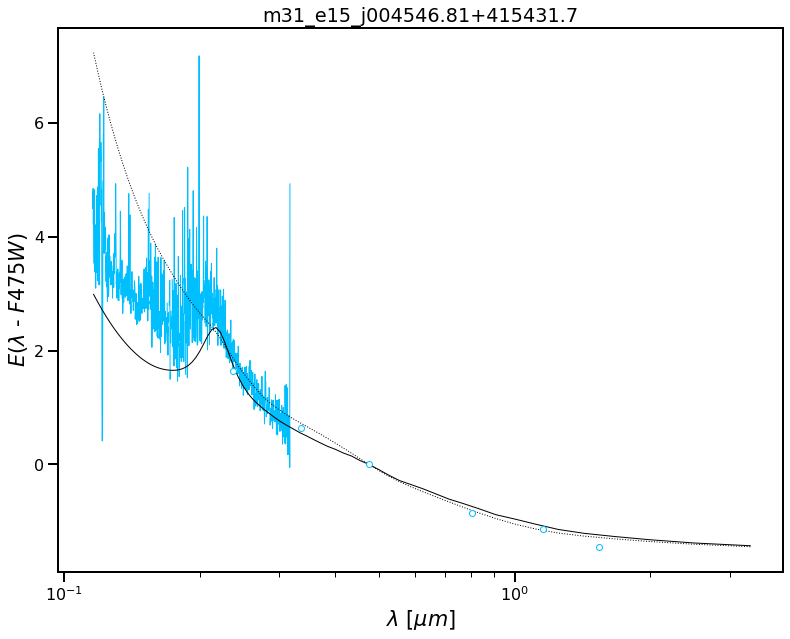

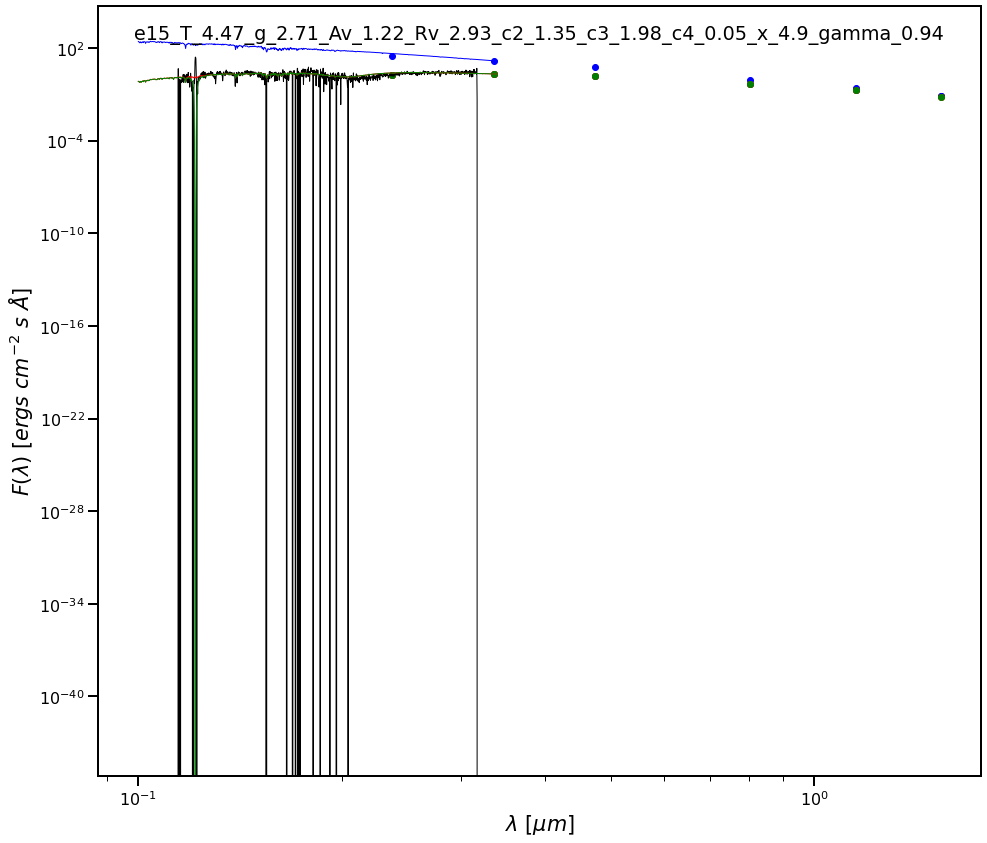

In [170]:
method="Nelder-Mead"#"Powell" 
star_str = starname.split("m31_")[1].split("_")[0]
print("star_str", star_str)
# outfolder = star_str + "/"
outfolder = "fit_/"

if not os.path.isdir(outfolder):
    print("making new dir", (outfolder))
    os.system("mkdir " + savefile_path + outfolder)
# outfolder = outfolder + subfolder

# Create weight arrays
weights = set_weights(data_names, reddened_star)

# params_grid = []
for i in range(len(logtgrid)):
    for j in range(len(logggrid)):
        for k in range(len(avgrid)):
            for l in range(len(c2grid)):
                for m in range(len(c3grid)):
                    for mn in range(len(c4grid)):
                        for n in range(len(x0grid)):
                            for o in range(len(gammagrid)):
                                for p in range(len(rvgrid)):
                                    pnames, \
                                    params, \
                                    plimits, \
                                    ppriors = setparams(logtgrid[i],
                                                        logggrid[j],
                                                        logzgrid[0],
                                                        av=avgrid[k],
                                                        rv=rvgrid[p],
                                                        c2=c2grid[l], 
                                                        c3=c3grid[m],
                                                        c4=c4grid[mn],
                                                        x0=x0grid[n],
                                                        g=gammagrid[o],
                                                        hig=hi_galgrid[0], 
                                                        himw=hi_mwgrid[0])
                                    
                                    fitinfo = package_fitinfo(pnames, plimits, weights, ppriors, velocity)

                                    # for e3 crashes with maxiter > 15
                                    result = log_l_to_chi2(fitinfo, 
                                                           params, 
                                                           reddened_star, 
                                                           modinfo,
                                                           method=method)

                                    params, \
                                    fit_params, \
                                    params_best, \
                                    pnames_extra = save_results(result, pnames)
                                    
                                    modsed, \
                                    ext_modsed, \
                                    hi_ext_modsed, \
                                    modsed_stardata, \
                                    extdata, \
                                    col_info = calc_plot_ext_curve(fit_params, velocity, 
                                                              relband, reddened_star, 
                                                              starname, params)
                                    
                                    # Plot obs & mod spectra (based on initial guess), and save it
                                    plot_spectra_with_mod(hi_ext_modsed, reddened_star, modsed, ext_modsed, 
                                                   modsed_stardata, starstr)
                                    print('\n\n')

### Plot the extinction curve - not needed?

True


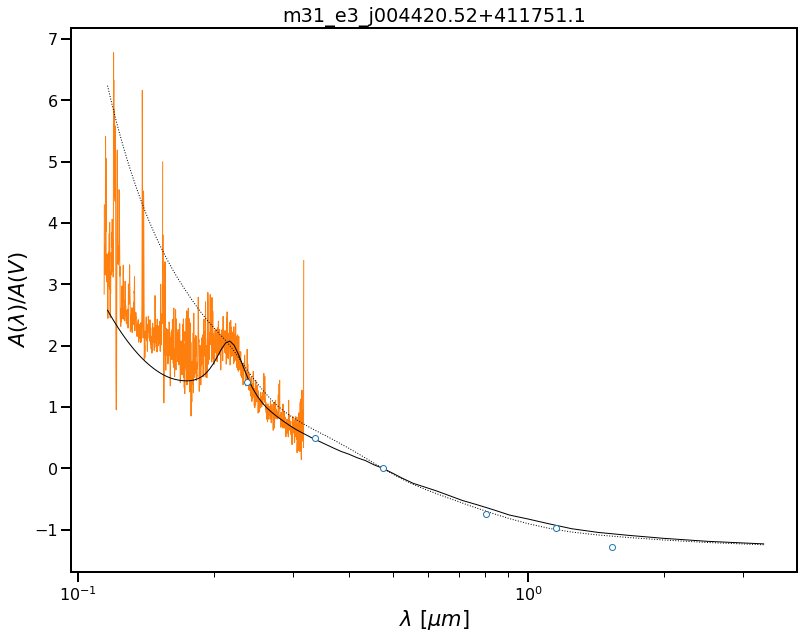

In [129]:
# # Plotting the same as previous cell - not needed
# fig, ax = plt.subplots(figsize=(13, 10))

# # convert from E(l-V) to A(l)/A(V)
# print(extdata.type_rel_band != "V")
# # extdata.columns["AV"] = (params[3], 0.0)
# # extdata.trans_elv_alav()

# extdata.plot(ax) #, alax=True)
# ax.set_xscale("log")
# ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
# # ax.set_ylim(0.0, 10.0)
# ax.set_ylabel(r"$A(\lambda)/A(V)$", fontsize=1.3 * fontsize)
# ax.tick_params("both", length=10, width=2, which="major")
# ax.tick_params("both", length=5, width=1, which="minor")

# # plot known exitnction curves
# mod_x = np.arange(0.3, 8.7, 0.1) / u.micron
# smcbar = G03_SMCBar()
# Af475wAv = smcbar(0.475 * u.micron)
# smcbar_el475w = (smcbar(mod_x) - Af475wAv) * params[3]
# ax.plot(1.0 / mod_x, smcbar_el475w, "k:")

# f19_rv31 = F19(Rv=3.1)
# Af475wAv = f19_rv31(0.475 * u.micron)
# f19_el475w = (f19_rv31(mod_x) - Af475wAv) * params[3]
# ax.plot(1.0 / mod_x, f19_el475w, "k-")
# ax.set_title("%s" % starname)
# plt.savefig(savefile_path + "extcurve_" + starname + ".png")

### Run emcee MCMC sampler to define uncertainties (bonus section)

In [164]:
importlib.reload(measure_extinction.utils.fit_model)
from measure_extinction.utils.fit_model import get_best_fit_params

p0 = params
ndim = len(p0)
print("p0", p0)

#nwalkers = 2 * ndim
#nsteps = 50
#burn = 50

nwalkers = 100
nsteps = 500 #10,000
burn = 500

# setting up the walkers to start "near" the inital guess
p = [p0 * (1 + 0.01 * np.random.normal(0, 1.0, ndim)) for k in range(nwalkers)]

# setup the sampler
print("setting up sampler")
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, fitinfo.lnprob, args=(reddened_star, modinfo, fitinfo)
)
print("done setting up sampler")

# print("FITINFO", fitinfo)

# burn in the walkers
pos, prob, state = sampler.run_mcmc(p, burn)

# reset the sampler
sampler.reset()

# do the full sampling
pos, prob, state = sampler.run_mcmc(pos, nsteps, rstate0=state)
# print ("pos", pos)
# print ("prob", prob)
# print ("state", state)

# create the samples variable for later use
samples = sampler.chain.reshape((-1, ndim))
print("len samples", len(samples))

# get the best fit values
pnames_extra = pnames + ["E(B-V)", "N(HI)/A(V)", "N(HI)/E(B-V)"]
params_best = get_best_fit_params(sampler)
fit_params = params_best
print("star", starstr)
print("best params")
print(params_best)

# get the 16, 50, and 84 percentiles
params_per = get_percentile_params(samples)
for k, val in enumerate(params_per):
    print(
        "{} {} {} {} # {}".format(
            params_best[k], val[0], val[1], val[2], pnames_extra[k]
        )
    )

p0 [ 4.47187348e+00  2.71040118e+00 -8.15366233e-04  1.22450068e+00
  2.92536389e+00  1.35014808e+00  1.98329202e+00  5.49829092e-02
  4.89999967e+00  9.44559523e-01  1.99487238e+01  2.14166480e+01]
setting up sampler
done setting up sampler


/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


len samples 50000
star e15
best params
[ 4.37578414e+00  2.48171656e+00 -9.04892305e-04  1.07297714e+00
  2.77106996e+00  1.35733391e+00  1.89279744e+00  5.03134544e-02
  4.85283744e+00  9.47463800e-01  2.10632114e+01  2.12397790e+01
  3.87206802e-01  1.07800527e+21  2.98722803e+21]
4.375784139305682 4.383677234201143 0.043147734449906494 0.004302037498341349 # logT
2.481716555234692 2.46473840698972 0.04253885121113621 0.005015840344202882 # logg
-0.0009048923049832686 -0.0008936661287488072 3.807436682732755e-05 4.140794405637033e-05 # logZ
1.072977137023485 1.0839020166586588 0.07930431709547614 0.008872281166190543 # Av
2.771069962190723 2.7818309462035695 0.10293744892399781 0.01992318486795197 # Rv
1.3573339090197654 1.3556127120320578 0.00839943626470907 0.020144463051897876 # C2
1.8927974395310685 1.9201971484016611 0.09521560299728637 0.03336319930382148 # C3
0.050313454371968706 0.05006018243886638 0.001394478848042023 0.0015578623518463716 # C4
4.852837436437609 4.8793804699

### Record best fit params + uncert. to dat file

In [165]:
# save the best fit and p50 +/- uncs values to a file
# save as a single row table to provide a uniform format
f = open("params_dat/" + starstr + "_fit_params.dat", "w")
#f.write("# best fit, p50, +unc, -unc\n")

params_per = get_percentile_params(samples)

print("saving params...")
for k, val in enumerate(params_per):
    f.write(
        "{} {} {} {} # {}\n".format(
           params_best[k], val[0], val[1], val[2], pnames_extra[k]
        )
    )

saving params...


### Calc & save ext curve with new best fit params
#### (now fit_params = params; also params_best = params &  pnames_extra = pnames)

In [166]:
# intrinsic sed
modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

# dust_extinguished sed
ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

# hi_abs sed
hi_ext_modsed = modinfo.hi_abs_sed(
    fit_params[10:12], [velocity, 0.0], ext_modsed
)

# create a StarData object for the best fit SED
modsed_stardata = modinfo.SED_to_StarData(modsed)

# create an extincion curve and save it
extdata = ExtData()
extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
col_info = {"av": fit_params[3], "rv": fit_params[4]}
extdata.save("extcurves/" + starstr + "_ext.fits", column_info=col_info)

[1.20165640e+09 1.20119364e+09 1.13232144e+09 ... 9.35450100e+07
 9.31554505e+07 9.27500119e+07] erg / (Angstrom cm2 s)


### Plot new best-fit model spectra

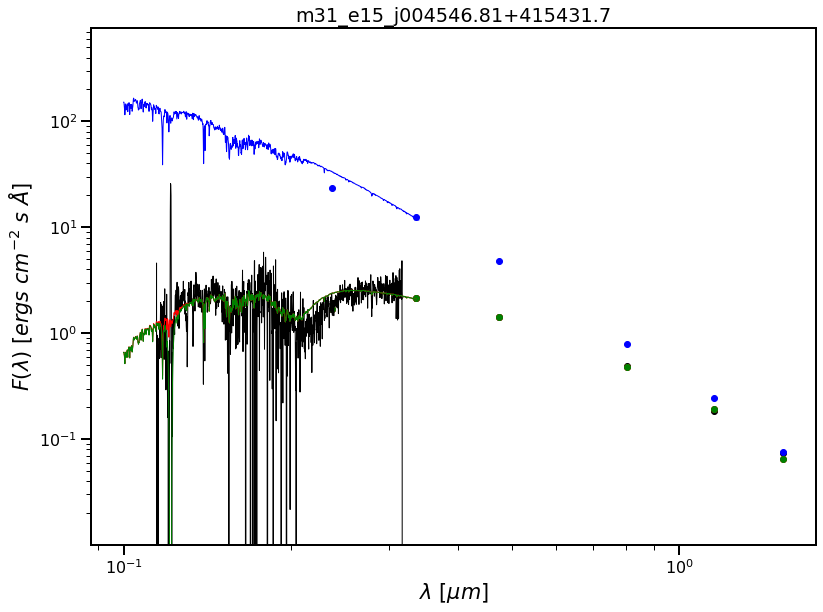

In [167]:
norm_model = np.average(hi_ext_modsed["BAND"])
norm_data = np.average(reddened_star.data["BAND"].fluxes)

# plotting setup for easier to read plots
fontsize = 16
font = {"size": fontsize}
mpl.rc("font", **font)
mpl.rc("lines", linewidth=1)
mpl.rc("axes", linewidth=2)
mpl.rc("xtick.major", width=2)
mpl.rc("xtick.minor", width=2)
mpl.rc("ytick.major", width=2)
mpl.rc("ytick.minor", width=2)

# setup the plot
fig, ax = plt.subplots(figsize=(13, 9.5))

# plot the bands and all spectra for this star
for cspec in modinfo.fluxes.keys():
    if cspec == "BAND":
        ptype = "o"
    else:
        ptype = "-"

    # ax.plot(reddened_star.data[cspec].waves,
    #        weights[cspec], 'k-')

    ax.plot(
        reddened_star.data[cspec].waves,
        reddened_star.data[cspec].fluxes / norm_data,
        "k" + ptype,
        label="data",
    )

    # print(reddened_star.data[cspec].waves)
    # print(modinfo.waves[cspec])

    ax.plot(
        modinfo.waves[cspec], modsed[cspec] / norm_model, "b" + ptype, label=cspec
    )
    ax.plot(
        modinfo.waves[cspec],
        ext_modsed[cspec] / norm_model,
        "r" + ptype,
        label=cspec,
    )
    ax.plot(
        modinfo.waves[cspec],
        hi_ext_modsed[cspec] / norm_model,
        "g" + ptype,
        label=cspec,
    )

# finish configuring the plot
ax.set_ylim(8e4 / norm_model, 6e9 / norm_model)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# ax.legend()

# use the whitespace better
# fig.tight_layout()
plt.title(starname)
plt.savefig(savefile_path + starstr + "_spectra2" + ".png")

### Plot new best-fit extinction curve

True


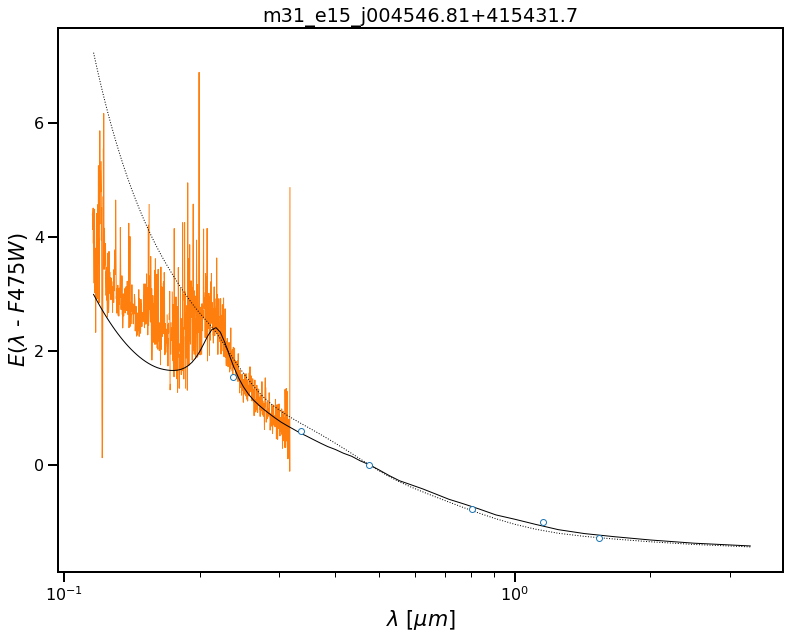

In [168]:
fig, ax = plt.subplots(figsize=(13, 10))

# convert from E(l-V) to A(l)/A(V)
print(extdata.type_rel_band != "V")
extdata.columns["AV"] = (params[3], 0.0)
# extdata.trans_elv_alav()

# def trans_elv_elvebv
extdata.plot(ax) #, alax=True)
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
#ax.set_ylim(0.0, 10.0)
# ax.set_ylabel(r"$A(\lambda)/A(V)$", fontsize=1.3 * fontsize)
ax.set_ylabel(fr"$E(\lambda$ - %s)" % relband_str, fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# plot known exitnction curves
mod_x = np.arange(0.3, 8.7, 0.1) / u.micron
smcbar = G03_SMCBar()
# ax.plot(1.0 / mod_x, smcbar(mod_x), "k:")
Af475wAv = smcbar(0.475 * u.micron)
smcbar_el475w = (smcbar(mod_x) - Af475wAv) * params[3]
ax.plot(1.0 / mod_x, smcbar_el475w, "k:")

f19_rv31 = F19(Rv=3.1)
# ax.plot(1.0 / mod_x, f19_rv31(mod_x), "k-")
# ax.set_xlim(0, 7.5)
Af475wAv = f19_rv31(0.475 * u.micron)
f19_el475w = (f19_rv31(mod_x) - Af475wAv) * params[3]
ax.plot(1.0 / mod_x, f19_el475w, "k-")
plt.title(starname)
plt.savefig(savefile_path + starstr + "_extcurve2" + ".png")
